# Introduction

We have been given a dataset containing the data of images of wells, the wells are ordered in columns and rows into the well plate. The wells contain bacteria that react with gold and change their color accordingly, we want to predict the gold concentration of wells. The dataset features are many and relating the well positioning, the camera settings and the "image channel" settings. The labels are `class_target`, that is the "class of concentration", and the `value_target`, that is the concentration of gol itself.

The unit of measure of concentration in `class_target` used is "CFU/ml". CFU stands for Colony Forming Units, which is a measure used in microbiology to estimate the number of viable bacteria or fungal cells in a sample. It's not a direct measurement of the total quantity of bacteria, but rather a measure of the number of cells capable of dividing and forming colonies.In simple words, it is the number of "units of bacteria" capable of forming colonies, therefore "CFU/ml" it's "units of bacteria capable of forming colonies in a milliliter of liquid".

In [1]:
import pandas as pd

df = pd.read_pickle('df.pkl')

We define some utils

In [2]:
from utils import print_full_classification_report, print_full_regression_report, create_training_history_plot, get_features, RegressionClassifier

# Dataset analysis and simplification

We notice that most features are numeric, we ask ourselves if we can perform training on a dataset with only numeric features.

In [3]:
LABEL_COLUMNS = ['class_target', 'value_target']
CLASSES = sorted(df['class_target'].unique())
CLASSES_SHORT = [class_.split(' CFU:mL')[0] for class_ in CLASSES]
FEATURES_COLUMNS = [col for col in df.columns if col not in LABEL_COLUMNS]

# Print numeric features and one example value using pd.api.types.is_numeric_dtype
NUMERICAL_FEATURES = [col for col in FEATURES_COLUMNS if pd.api.types.is_numeric_dtype(df[col])]
CATEGORICAL_FEATURES = [col for col in FEATURES_COLUMNS if col not in NUMERICAL_FEATURES]

print('Number of numeric features:', len(NUMERICAL_FEATURES))
print('Number of categorical features:', len(CATEGORICAL_FEATURES))
print(f'Total number of features: {len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES)}')
print(f'Percentage of categorical features: {len(CATEGORICAL_FEATURES) / len(df.columns) * 100}%')
print(f'Percentage of numeric features: {len(NUMERICAL_FEATURES) / len(df.columns) * 100}%')

print('Numeric features:')
for col in NUMERICAL_FEATURES:
    print(f'\t{col}: {df[col].iloc[0]}')

print('Categorical features:')
for col in CATEGORICAL_FEATURES:
    print(f'\t{col}: {df[col].iloc[0]}')

Number of numeric features: 167
Number of categorical features: 11
Total number of features: 178
Percentage of categorical features: 6.111111111111111%
Percentage of numeric features: 92.77777777777779%
Numeric features:
	wp_image_prop: 0.0
	mock: False
	FocalLengthIn35mmFilm: 0.0
	ISOSpeedRatings: 226.0
	Orientation: 1.0
	Flash: 16.0
	MeteringMode: 2.0
	full_gray_mean: 76.37894375857339
	full_gray_stddev: 42.19194116854811
	full_gray_mean_trm30: 89.51971710244321
	full_gray_skewness: -0.985075922379453
	full_gray_entropy: 4.823225765539228
	full_gray_entropy2: 3.3432053405876
	full_gray_entropy_glcm: 7.1244046874085125
	full_gray_mean_PIL: 76.37894375857339
	full_blue_mean: 66.73251028806584
	full_blue_stddev: 38.11588827465449
	full_blue_mean_trm30: 75.86755250750107
	full_blue_skewness: -0.7398326957511079
	full_blue_entropy: 4.923509474933315
	full_blue_entropy2: 3.4127167110102032
	full_blue_entropy_glcm: 7.267878672884646
	full_blue_mean_PIL: 66.73251028806584
	full_green_mean: 6

We decide to drop the categorical features, because we want to experiment if models trained on a dataset with only numeric features will be good enough.

In [4]:
# Drop categorical features
df_numeric = df.drop(columns=CATEGORICAL_FEATURES)

FEATURES_COLUMNS = [col for col in df_numeric.columns if col not in LABEL_COLUMNS]

We drop features with no variance, because they are useless

In [5]:
# Drop feature that are constant
CONSTANT_FEATURES = [col for col in FEATURES_COLUMNS if df_numeric[col].nunique() == 1]
df_numeric = df_numeric.drop(columns=CONSTANT_FEATURES)

FEATURES_COLUMNS = [col for col in df_numeric.columns if col not in LABEL_COLUMNS]

# Feature selection

We perform feature selection using different methods

### Correlation calculations

We calculate Pearson correlation between features and we drop the features

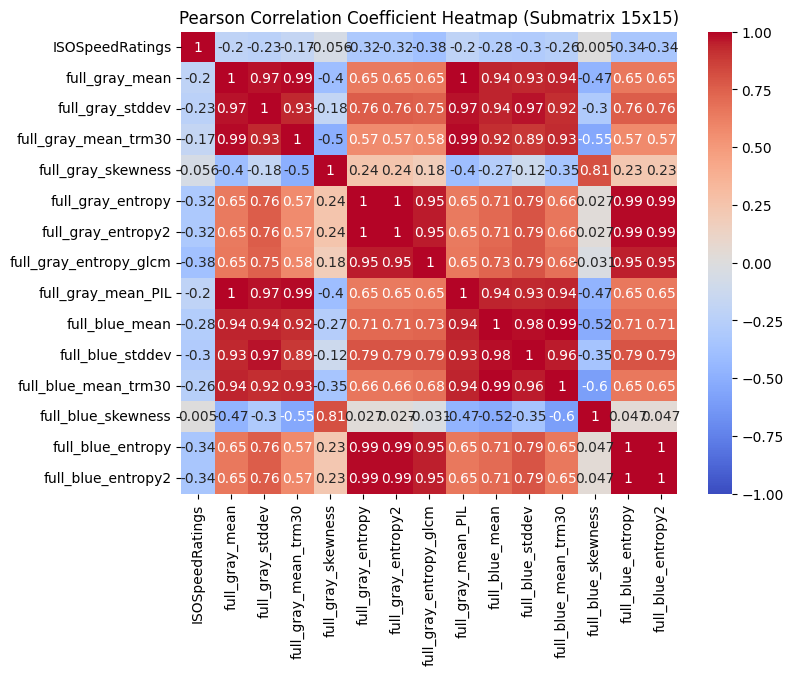

Dropped 147 columns with correlation coefficient above 0.8: {'S_skewness', 'full_L_skewness', 'V_entropy_glcm', 'a_mean_PIL', 'b_skewness', 'S_stddev', 'S_entropy', 'H_skewness', 'full_red_mean_trm30', 'red_mean_PIL', 'full_blue_mean', 'full_V_mean_PIL', 'red_skewness', 'red_entropy', 'V_skewness', 'full_S_mean_trm30', 'full_V_skewness', 'L_mean', 'red_entropy2', 'full_V_entropy', 'full_green_skewness', 'full_a_entropy', 'full_a_entropy_glcm', 'red_mean', 'L_mean_trm30', 'S_mean_trm30', 'full_green_mean_trm30', 'full_H_stddev', 'green_entropy', 'red_mean_trm30', 'full_b_mean_trm30', 'full_green_mean_PIL', 'full_H_mean_trm30', 'full_red_entropy2', 'blue_mean', 'blue_skewness', 'S_mean_PIL', 'full_green_entropy2', 'V_mean_PIL', 'a_mean_trm30', 'L_skewness', 'full_L_entropy_glcm', 'full_gray_mean_trm30', 'blue_mean_trm30', 'V_stddev', 'full_b_entropy_glcm', 'full_green_stddev', 'full_b_mean', 'full_L_mean_PIL', 'full_blue_entropy_glcm', 'H_mean', 'blue_entropy', 'full_b_entropy2', 'full_L

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pearson correlation coefficient
SUBMATRIX_SIZE = 15
correlation_matrix_numeric = df_numeric[FEATURES_COLUMNS].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_numeric.iloc[:SUBMATRIX_SIZE, :SUBMATRIX_SIZE], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficient Heatmap (Submatrix {SUBMATRIX_SIZE}x{SUBMATRIX_SIZE})')
plt.show()

# Set the correlation threshold
threshold = 0.8

# Create a mask to identify columns to drop
to_drop = set()
for i in range(len(correlation_matrix_numeric.columns)):
    for j in range(i):
        if abs(correlation_matrix_numeric.iloc[i, j]) > threshold:
            colname = correlation_matrix_numeric.columns[i]
            to_drop.add(colname)

# Drop the identified columns
df_numeric_dropped = df_numeric.drop(columns=to_drop)
FEATURES_COLUMNS = [col for col in df_numeric_dropped.columns if col not in LABEL_COLUMNS]

print(f"Dropped {len(to_drop)} columns with correlation coefficient above {threshold}: {to_drop}")
print(f"There are {len(FEATURES_COLUMNS)} remaining features")

# Save df_onehot_dropped and correlation_matrix_numeric to pickle files
df_numeric_dropped.to_pickle('df_numeric_dropped.pkl')
correlation_matrix_numeric.to_pickle('correlation_matrix_numeric.pkl')

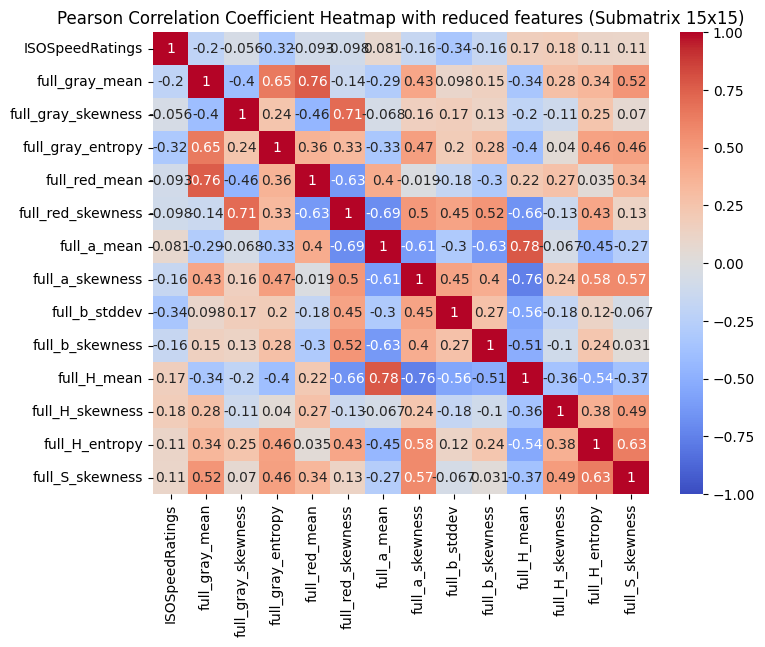

In [7]:
# Import df_onehot_dropped from a pickle file
import pandas as pd
import seaborn as sns

df_numeric_dropped = pd.read_pickle('df_numeric_dropped.pkl')
correlation_matrix_numeric = pd.read_pickle('correlation_matrix_numeric.pkl')

# Plot the heatmap of the remaining features
FEATURES_COLUMNS = [col for col in df_numeric_dropped.columns if col not in LABEL_COLUMNS]
SUBMATRIX_SIZE = 15
correlation_matrix_numeric_dropped = correlation_matrix_numeric[FEATURES_COLUMNS].loc[FEATURES_COLUMNS]

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_numeric_dropped.iloc[:SUBMATRIX_SIZE, :SUBMATRIX_SIZE], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficient Heatmap with reduced features (Submatrix {SUBMATRIX_SIZE}x{SUBMATRIX_SIZE})')
plt.show()

We notice that with a treshold of 0.8, we drop 147 numeric features and we are left with only 14 features. We keep going on.

We also notice that with our previous method, using one hot encoding of categorical features, we dropped in total 148 features, that means that 147 were numeric. Probably there was an error with approach? Or maybe categorical features have much less correlation with each other. - CHECK - find an answer

We calculate chi-squared correlation with the each feature with the label `class_target`, we drop the columns with a correlation below a threshold

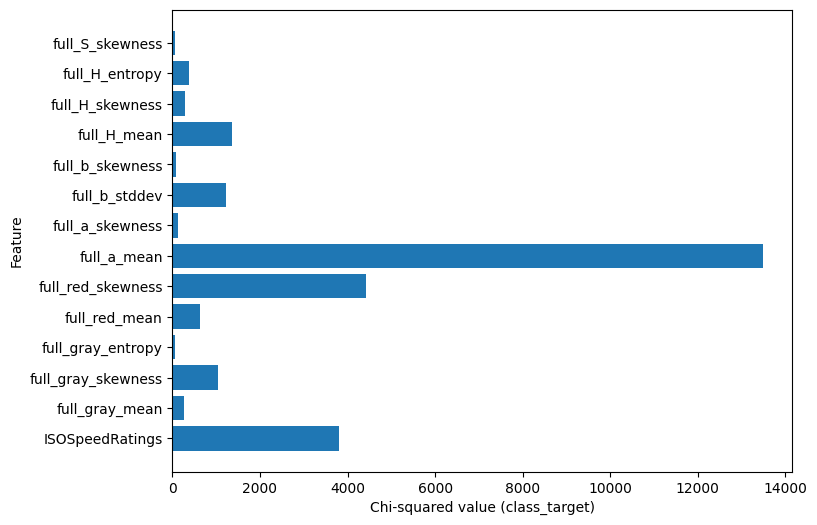

Mean of chi-squared values: 1947.5067018015345
Standard deviation of chi-squared values: 3463.9788713925836
Threshold for chi-squared values: 215.5172661052427
FEATURES_COLUMNS = ['ISOSpeedRatings', 'full_gray_mean', 'full_gray_skewness', 'full_gray_entropy', 'full_red_mean', 'full_red_skewness', 'full_a_mean', 'full_a_skewness', 'full_b_stddev', 'full_b_skewness', 'full_H_mean', 'full_H_skewness', 'full_H_entropy', 'full_S_skewness']
chi2_values = [ 3796.87198234   270.7371623   1045.75692838    66.79721309
   641.02645681  4420.7805857  13486.41456769   125.99226042
  1234.08433349    73.68515238  1371.64728261   298.29224567
   379.96472713    53.04292721]
First 10 features sorted by ascending chi-squared value:
	('full_a_mean', 13486.414567685228)
	('full_red_skewness', 4420.7805856985815)
	('ISOSpeedRatings', 3796.871982344184)
	('full_H_mean', 1371.64728260557)
	('full_b_stddev', 1234.084333492684)
	('full_gray_skewness', 1045.7569283815214)
	('full_red_mean', 641.0264568128798)


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

df_numeric_dropped = pd.read_pickle('df_numeric_dropped.pkl')

# Convert categorical target to numeric values
le = LabelEncoder()
y_class_target = le.fit_transform(df_numeric_dropped["class_target"])

# Select categorical features for chi-squared test
FEATURES_COLUMNS = [col for col in df_numeric_dropped.columns if col not in LABEL_COLUMNS]

# # Apply non-negative transformation (MinMaxScaler) to the input data because chi-squared test requires non-negative values
scaler = MinMaxScaler()
X_features = scaler.fit_transform(df_numeric_dropped[FEATURES_COLUMNS])

# Chi-squared test
chi2_values, p_values = chi2(X_features, y_class_target)

# Create a plot for the chi-squared values
NUMBER_OF_FEATURES_TO_PLOT = 15

plt.figure(figsize=(8, 6))
plt.barh(FEATURES_COLUMNS[:NUMBER_OF_FEATURES_TO_PLOT], chi2_values[:NUMBER_OF_FEATURES_TO_PLOT])
plt.xlabel('Chi-squared value (class_target)')
plt.ylabel('Feature')
le = LabelEncoder()
y = le.fit_transform(df_numeric_dropped["class_target"])
plt.show()

# Calculate the threshold for chi-squared values making mean plus k standard deviations
print(f"Mean of chi-squared values: {chi2_values.mean()}")
print(f"Standard deviation of chi-squared values: {chi2_values.std()}")

k = - 1/2
threshold = chi2_values.mean() + k * chi2_values.std()

print(f"Threshold for chi-squared values: {threshold}")

# Sort features by chi-squared value using sorted
print(f"FEATURES_COLUMNS = {FEATURES_COLUMNS}")
print(f"chi2_values = {chi2_values}")

feature_columns_with_chi_squared_value = sorted(zip(FEATURES_COLUMNS, chi2_values), key=lambda x: x[1], reverse=True)
# Update FEATURES_COLUMNS and chi2_values
FEATURES_COLUMNS, chi2_values = zip(*feature_columns_with_chi_squared_value)

# First 10 features
print(f"First 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{feature_columns_with_chi_squared_value[i]}")

# Last 10 features
print(f"Last 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{feature_columns_with_chi_squared_value[-i - 1]}")

# Drop columns with chi-squared value below the threshold
to_drop = [col for col, chi2_val in zip(FEATURES_COLUMNS, chi2_values) if chi2_val < threshold]
print(f"Columns with chi-squared value below {threshold}: {to_drop}")
df_numeric_dropped_chi2 = df_numeric_dropped.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} columns with chi-squared value below {threshold}: {to_drop}")

# Save df_numeric_dropped_chi2 to a pickle file
df_numeric_dropped_chi2.to_pickle('df_numeric_dropped_chi2.pkl')

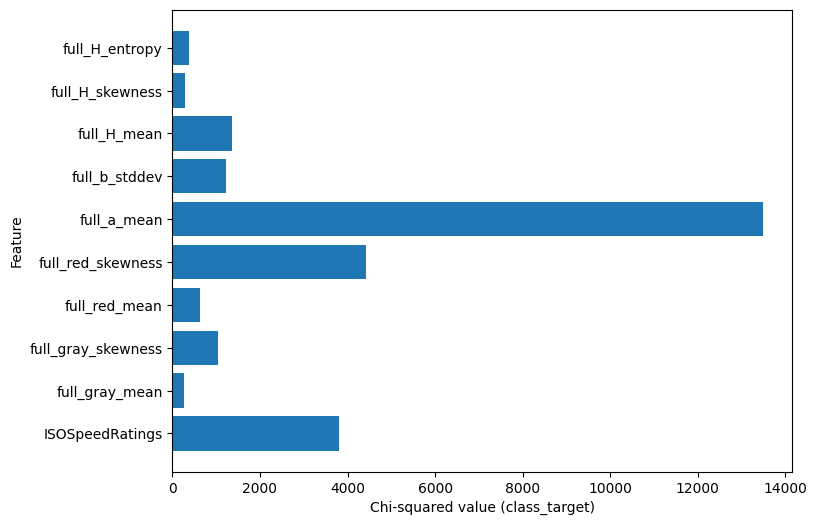

FEATURES_COLUMNS: ['full_a_mean', 'full_red_skewness', 'ISOSpeedRatings', 'full_H_mean', 'full_b_stddev', 'full_gray_skewness', 'full_red_mean', 'full_H_entropy', 'full_H_skewness', 'full_gray_mean']
First 10 features sorted by ascending chi-squared value:
	full_a_mean: 3796.871982344184
	full_red_skewness: 270.7371623011593
	ISOSpeedRatings: 1045.7569283815214
	full_H_mean: 641.0264568128798
	full_b_stddev: 4420.7805856985815
	full_gray_skewness: 13486.414567685228
	full_red_mean: 1234.084333492684
	full_H_entropy: 1371.64728260557
	full_H_skewness: 298.292245671273
	full_gray_mean: 379.9647271271967
Last 10 features sorted by ascending chi-squared value:
	full_gray_mean: 379.9647271271967
	full_H_skewness: 298.292245671273
	full_H_entropy: 1371.64728260557
	full_red_mean: 1234.084333492684
	full_gray_skewness: 13486.414567685228
	full_b_stddev: 4420.7805856985815
	full_H_mean: 641.0264568128798
	ISOSpeedRatings: 1045.7569283815214
	full_red_skewness: 270.7371623011593
	full_a_mean: 3

In [9]:
# Import df_numeric_dropped_chi2 from a pickle file
df_numeric_dropped_chi2 = pd.read_pickle('df_numeric_dropped_chi2.pkl')

# Create a new plot for the Chi-squared values
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

FEATURES_COLUMNS = [col for col in df_numeric_dropped_chi2.columns if col not in LABEL_COLUMNS]
scaler = MinMaxScaler()
le = LabelEncoder()
X_features = scaler.fit_transform(df_numeric_dropped_chi2[FEATURES_COLUMNS])
y_class_target = le.fit_transform(df_numeric_dropped_chi2["class_target"])
chi2_values, _ = chi2(X_features, y_class_target)
plt.figure(figsize=(8, 6))
NUMBER_OF_FEATURES_TO_PLOT = 15
plt.barh(FEATURES_COLUMNS[:NUMBER_OF_FEATURES_TO_PLOT], chi2_values[:NUMBER_OF_FEATURES_TO_PLOT])
plt.xlabel('Chi-squared value (class_target)')
plt.ylabel('Feature')
plt.show()

# Sort features by chi-squared value using sorted
feature_columns_with_chi_squared_value = sorted(zip(FEATURES_COLUMNS, chi2_values), key=lambda x: x[1], reverse=True)
FEATURES_COLUMNS = [col for col, chi2_val in feature_columns_with_chi_squared_value]

df_numeric_dropped_chi2_sorted = df_numeric_dropped_chi2[FEATURES_COLUMNS + LABEL_COLUMNS]
print(f"FEATURES_COLUMNS: {FEATURES_COLUMNS}")

# Print the first 10 features sorted by ascending chi-squared value
print(f"First 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{FEATURES_COLUMNS[i]}: {chi2_values[i]}")

# Print the last 10 features sorted by ascending chi-squared value
print(f"Last 10 features sorted by ascending chi-squared value:")
for i in range(10):
    print(f"\t{FEATURES_COLUMNS[-i - 1]}: {chi2_values[-i - 1]}")

df_numeric_dropped_chi2_sorted.to_pickle('df_numeric_dropped_chi2_sorted.pkl')
    
# TODO - CHECK: understand why since value_target is continuous, it is not possible to apply chi-squared
# # Do the same for value_target (numeric feature)
# # Apply non-negative transformation to the input data
# scaler = MinMaxScaler()
# X = scaler.fit_transform(df_numeric_dropped_chi2[FEATURES_COLUMNS])
# y = df["value_target"]

# # Chi-squared test
# chi2_values, p_values = chi2(X, y)

# # Create a plot for the chi-squared values
# plt.figure(figsize=(8, 6))
# plt.barh(FEATURES_COLUMNS, chi2_values)
# plt.xlabel('Chi-squared value (value_target)')
# plt.ylabel('Feature')
# plt.show()

# # Drop columns with chi-squared value below a threshold
# threshold = 0.1
# to_drop = [col for col, chi2_val in zip(FEATURES_COLUMNS, chi2_values) if chi2_val < threshold]
# df_numeric_dropped_chi2 = df_numeric_dropped_chi2.drop(columns=to_drop)

# # Create a new plot for the Chi-squared values
# FEATURES_COLUMNS = [col for col in df_numeric_dropped_chi2.columns if col not in LABEL_COLUMNS]
# chi2_values, _ = chi2(X, y)
# plt.figure(figsize=(8, 6))
# plt.barh(FEATURES_COLUMNS, chi2_values)
# plt.xlabel('Chi-squared value (value_target)')
# plt.ylabel('Feature')
# plt.show()

We do feature importance, just to compare

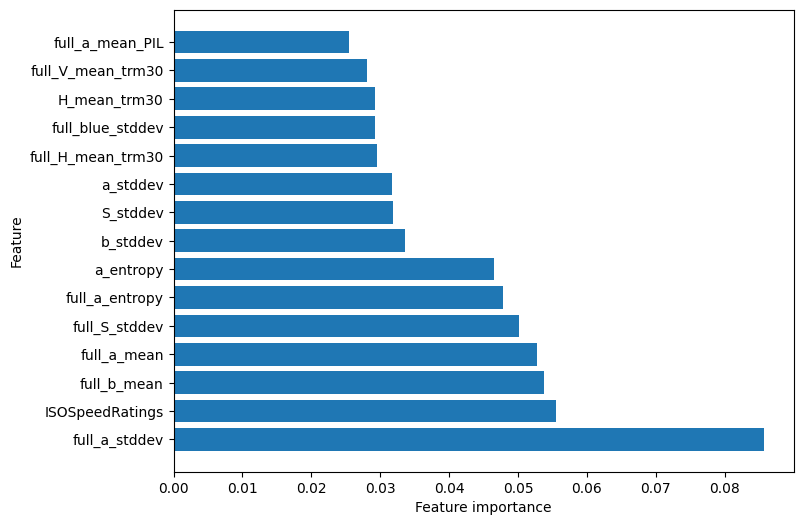

1. full_a_stddev: 0.08571305357774804
2. ISOSpeedRatings: 0.05552944962688182
3. full_b_mean: 0.053816062470457816
4. full_a_mean: 0.052727367867900096
5. full_S_stddev: 0.05008794740840592
6. full_a_entropy: 0.047871792409490604
7. a_entropy: 0.04654540245815374
8. b_stddev: 0.033598214434495
9. S_stddev: 0.03181263003160516
10. a_stddev: 0.031665715960830315
11. full_H_mean_trm30: 0.029473623727282107
12. full_blue_stddev: 0.029311040876938255
13. H_mean_trm30: 0.02927286898009841
14. full_V_mean_trm30: 0.028087863302090243
15. full_a_mean_PIL: 0.02550129574874377
16. full_b_mean_trm30: 0.02334395944551481
17. H_stddev: 0.02121807658028744
18. S_entropy_glcm: 0.02027898180689856
19. red_skewness: 0.02015993534518214
20. full_V_mean_PIL: 0.017880806573760122
21. a_mean_PIL: 0.015582204616555354
22. L_mean: 0.014577708010381201
23. full_blue_mean_trm30: 0.014162624044215085
24. full_b_stddev: 0.011630541308733106
25. a_mean: 0.01102714187352407
26. b_mean_PIL: 0.010835319385593834
27. 

In [10]:
# Do feature selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
FEATURES_COLUMNS = [col for col in df_numeric.columns if col not in LABEL_COLUMNS]
X = df_numeric[FEATURES_COLUMNS]
y = le.fit_transform(df_numeric["class_target"])

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Sort features by importance using sorted in descending order
feature_columns_with_importance = sorted(zip(FEATURES_COLUMNS, feature_importances), key=lambda x: x[1], reverse=True)
FEATURES_COLUMNS, feature_importances = zip(*feature_columns_with_importance)

# Create a plot for the feature importances
NUMBER_OF_FEATURES_TO_PLOT = 15
plt.figure(figsize=(8, 6))
plt.barh(FEATURES_COLUMNS[:NUMBER_OF_FEATURES_TO_PLOT], feature_importances[:NUMBER_OF_FEATURES_TO_PLOT])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

# Sort features by importance using sorted and print them
feature_columns_with_importance = sorted(zip(FEATURES_COLUMNS, feature_importances), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(feature_columns_with_importance):
    print(f"{i + 1}. {feature}: {importance}")

We save the X and y data

In [1]:
import pickle
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

df_numeric_dropped_chi2_sorted = pickle.load(open('df_numeric_dropped_chi2_sorted.pkl', 'rb'))
FEATURES_COLUMNS = [col for col in df_numeric_dropped_chi2_sorted.columns if col not in LABEL_COLUMNS]
scaler = MinMaxScaler()
le = LabelEncoder()

# MinMaxScaler is necessary otherwise K-means doesn't work well
X = scaler.fit_transform(df_numeric_dropped_chi2_sorted[FEATURES_COLUMNS])
# X = df_numeric_dropped_chi2_sorted[FEATURES_COLUMNS].to_numpy()
y = le.fit_transform(df_numeric_dropped_chi2_sorted["class_target"])

# Save to pickle file
pickle.dump(X, open('X_numeric.pkl', 'wb'))
pickle.dump(y, open('y_numeric.pkl', 'wb'))

NameError: name 'LABEL_COLUMNS' is not defined

# Dimensionality visualization

We won't perform densionality reduction. Let's visualize the date in 2 and 3 dimensions.

In [2]:
# Import X and y from a pickle files
import pickle

df_numeric_dropped_chi2_sorted = pickle.load(open('df_numeric_dropped_chi2_sorted.pkl', 'rb'))
X = pickle.load(open('X_numeric.pkl', 'rb'))
y = pickle.load(open('y_numeric.pkl', 'rb'))

# Plot the data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_xlabel(df_numeric_dropped_chi2_sorted.columns[0])
ax.set_ylabel(df_numeric_dropped_chi2_sorted.columns[1])
ax.set_zlabel(df_numeric_dropped_chi2_sorted.columns[2])
ax.set_title('Data in 3D')
ax.zaxis.labelpad=-1        # Improve visibility of the z-axis label
plt.show()


# Plot the data in the principal component space
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel(df_numeric_dropped_chi2_sorted.columns[0])
plt.ylabel(df_numeric_dropped_chi2_sorted.columns[1])
plt.title('Data in 2D')
plt.colorbar()


NameError: name 'plt' is not defined

# Training - Classification

Let's define the train and test set.

In [13]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

FEATURES_COLUMNS = [col for col in df_numeric_dropped_chi2.columns if col not in LABEL_COLUMNS]

# Open pickle files from X_numeric.pkl and y_numeric.pkl
X = pickle.load(open('X_numeric.pkl', 'rb'))
y = pickle.load(open('y_numeric.pkl', 'rb'))

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) # random_state set for reproducibility

# Print the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Print unique values of y_train and y_test
print()
print(f"Unique values of y_train: {np.unique(y_train)}")

# Print example of train and test data
print()
print("Example of train data:")
print(f"X_train[0]: {X_train[0]}")
print(f"y_train[0]: {y_train[0]}")

print()
print("Example of test data:")
print(f"X_test[0]: {X_test[0]}")
print(f"y_test[0]: {y_test[0]}")

# Save to pickle files
pickle.dump(X, open('X_numeric_classification.pkl', 'wb'))
pickle.dump(X_train, open('X_numeric_train_classification.pkl', 'wb'))
pickle.dump(X_test, open('X_numeric_test_classification.pkl', 'wb'))
pickle.dump(y, open('y_numeric_classification.pkl', 'wb'))
pickle.dump(y_train, open('y_numeric_train_classification.pkl', 'wb'))
pickle.dump(y_test, open('y_numeric_test_classification.pkl', 'wb'))


X_train shape: (49612, 10)
X_test shape: (12404, 10)
y_train shape: (49612,)
y_test shape: (12404,)

Unique values of y_train: [0 1 2 3 4 5]

Example of train data:
X_train[0]: [0.05826815 0.38631179 0.51459854 0.6063438  0.13494003 0.3510117
 0.48131182 0.51005743 0.01841794 0.51656526]
y_train[0]: 0

Example of test data:
X_test[0]: [0.10281676 0.37467539 0.01824818 0.62027645 0.1724398  0.35492347
 0.53003356 0.42169644 0.01913812 0.56865905]
y_test[0]: 1


We import the training and test data

In [14]:
# Import the training and test data from pickle files
import pickle

X = pickle.load(open('X_numeric_classification.pkl', 'rb'))
X_train = pickle.load(open('X_numeric_train_classification.pkl', 'rb'))
X_test = pickle.load(open('X_numeric_test_classification.pkl', 'rb'))
y = pickle.load(open('y_numeric_classification.pkl', 'rb'))
y_train = pickle.load(open('y_numeric_train_classification.pkl', 'rb'))
y_test = pickle.load(open('y_numeric_test_classification.pkl', 'rb'))

CLASSIFICATION_PLOT_AXES = ["full_a_mean", "full_red_skewness"]

We apply Naive Bayes, that has the model performance that we want to beat.

Accuracy: 0.912528216704289
Scatter plot of the test data:


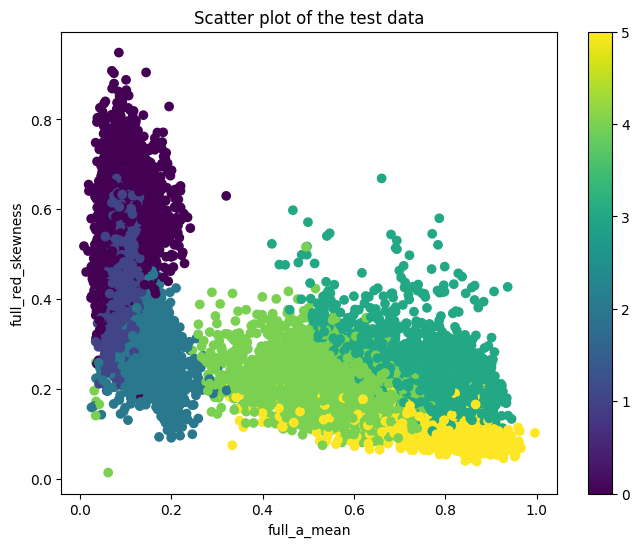

Confusion matrix:


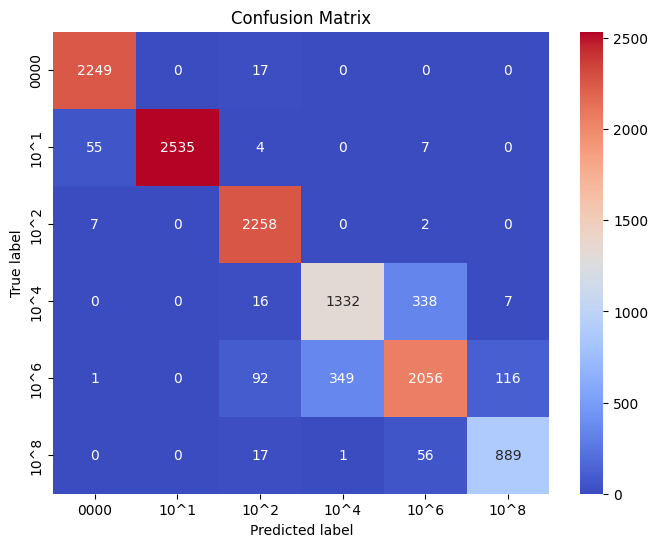

Classification Report:
              precision    recall  f1-score   support

        0000       0.97      0.99      0.98      2266
        10^1       1.00      0.97      0.99      2601
        10^2       0.94      1.00      0.97      2267
        10^4       0.79      0.79      0.79      1693
        10^6       0.84      0.79      0.81      2614
        10^8       0.88      0.92      0.90       963

    accuracy                           0.91     12404
   macro avg       0.90      0.91      0.91     12404
weighted avg       0.91      0.91      0.91     12404



In [15]:
# Apply Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Create an instance of the model
nb = GaussianNB()

# Fit the model to the training data
nb.fit(X_train, y_train)

# Predict the classes of the test data
y_pred = nb.predict(X_test)

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply K-means

y_test = array([1, 0, 2, ..., 2, 1, 0])
y_pred = array([1, 5, 2, ..., 2, 1, 5], dtype=int32)


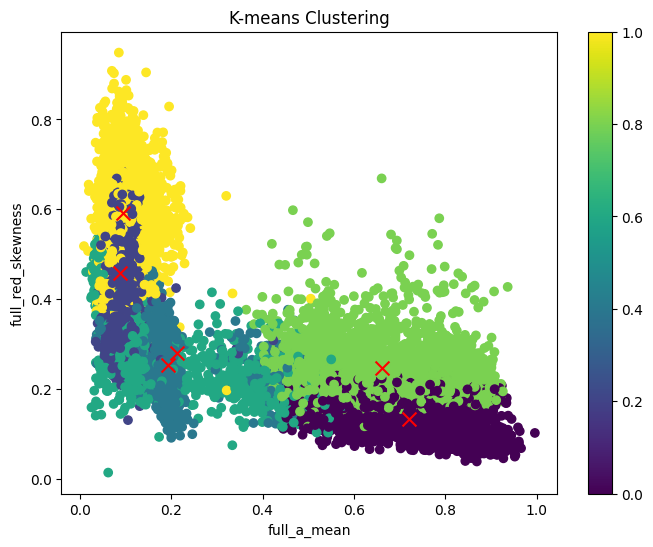

Accuracy: 0.480973879393744
Silhouette score: 0.3337139366177958
Inertia: 2948.5522617289816
Accuracy: 0.480973879393744
Scatter plot of the test data:


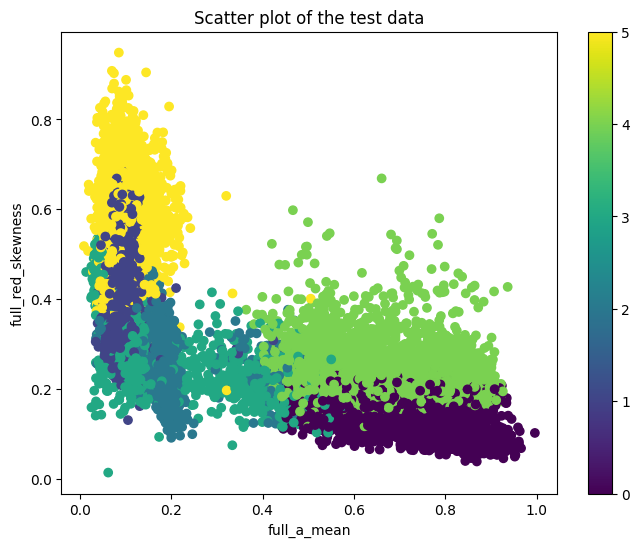

Confusion matrix:


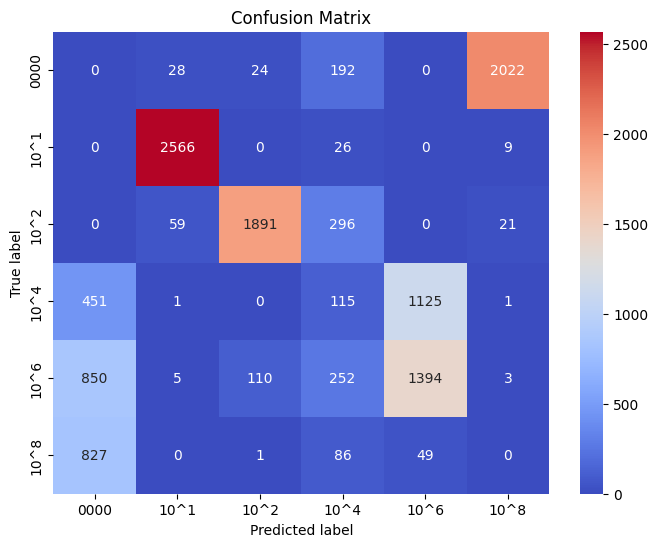

Classification Report:
              precision    recall  f1-score   support

        0000       0.00      0.00      0.00      2266
        10^1       0.97      0.99      0.98      2601
        10^2       0.93      0.83      0.88      2267
        10^4       0.12      0.07      0.09      1693
        10^6       0.54      0.53      0.54      2614
        10^8       0.00      0.00      0.00       963

    accuracy                           0.48     12404
   macro avg       0.43      0.40      0.41     12404
weighted avg       0.50      0.48      0.49     12404



In [16]:
# K-means is an unsupervised machine learning algorithm, what it does is "clustering". At the end of a clustering algorithm execution, you get clusters, that are set of points. We can associate each cluster to a class, according to some algorithm that we are currently developing, and then we get a supervised version of a clustering algorithm, because we just use the traning set features and albels (but in two separate steps).

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score

np.random.seed(5)

# Set the number of clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)

# Fit the K-means model to the data
kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)

print(f"{y_test = }")
print(f"{y_pred = }")

# Get the cluster centers
centroids = kmeans.cluster_centers_

# Plot the data and the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.xlabel(CLASSIFICATION_PLOT_AXES[0])
plt.ylabel(CLASSIFICATION_PLOT_AXES[1])
plt.title('K-means Clustering')
plt.colorbar()
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate the silhouette score
silhouette = silhouette_score(X_test, y_pred)
print(f"Silhouette score: {silhouette}")

# Calculate the intertia
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply K-medoids

In [17]:
# import numpy as np
# from sklearn_extra.cluster import KMedoids
# from sklearn.metrics import accuracy_score

# np.random.seed(5)

# # Set the number of clusters
# n_clusters = 6
# kmedoids = KMedoids(n_clusters=n_clusters)

# # Fit the K-means model to the data
# kmedoids.fit(X_train)
# y_pred = kmedoids.predict(X_test)

# # Get the cluster centers
# medoids = kmedoids.cluster_centers_

# # Plot the data and the cluster centers
# plt.figure(figsize=(8, 6))
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
# plt.scatter(medoids[:, 0], medoids[:, 1], c='red', marker='x', s=100)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('K-means Clustering')
# plt.colorbar()
# plt.show()

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Calculate the silhouette score
# silhouette = silhouette_score(X_test, y_pred)
# print(f"Silhouette score: {silhouette}")

# # Calculate the intertia
# inertia = kmedoids.inertia_
# print(f"Inertia: {inertia}")

We apply SVM

Accuracy: 0.9828281199613028
Scatter plot of the test data:


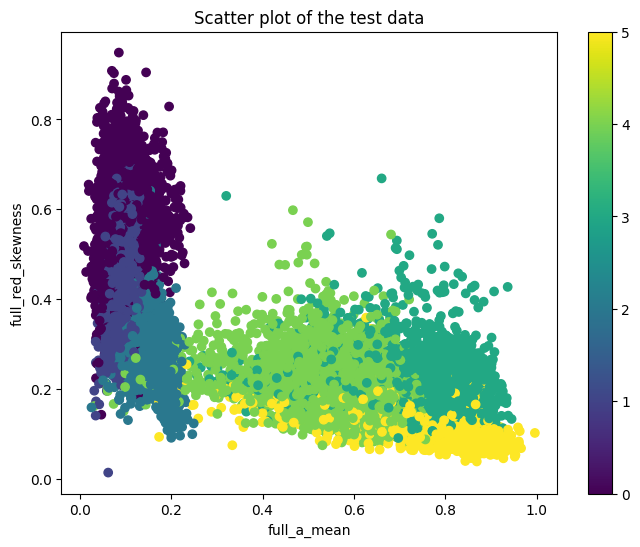

Confusion matrix:


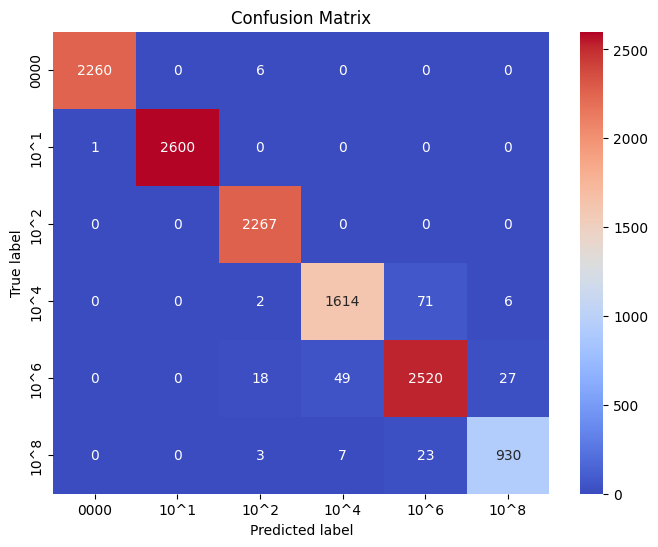

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      1.00      0.99      2267
        10^4       0.97      0.95      0.96      1693
        10^6       0.96      0.96      0.96      2614
        10^8       0.97      0.97      0.97       963

    accuracy                           0.98     12404
   macro avg       0.98      0.98      0.98     12404
weighted avg       0.98      0.98      0.98     12404



In [18]:
# Apply SVM
from sklearn.svm import SVC

# Set the SVM model
svm = SVC()

# Fit the SVM model to the data
svm.fit(X_train, y_train)

# Predict the labels
y_pred = svm.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply random forest

Accuracy: 0.9891970332150919
Scatter plot of the test data:


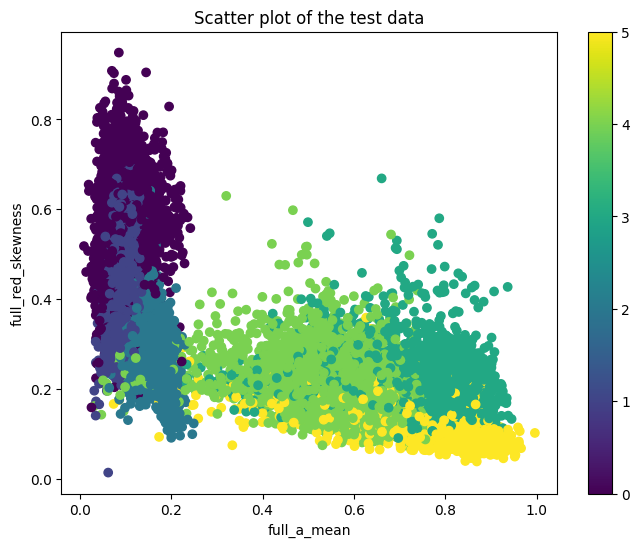

Confusion matrix:


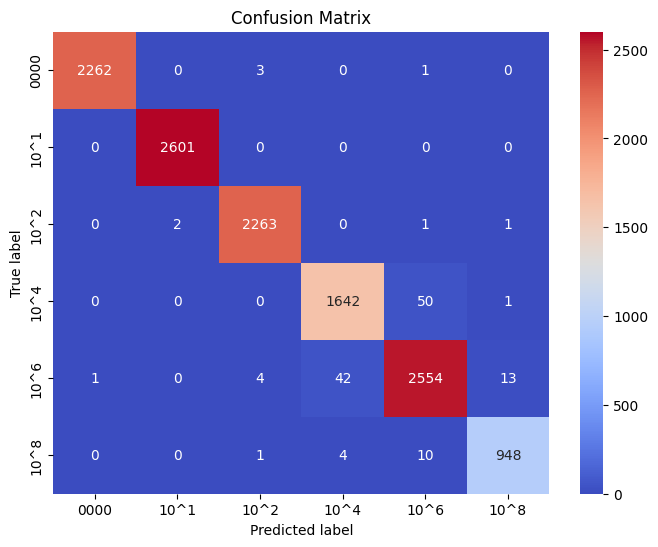

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       1.00      1.00      1.00      2267
        10^4       0.97      0.97      0.97      1693
        10^6       0.98      0.98      0.98      2614
        10^8       0.98      0.98      0.98       963

    accuracy                           0.99     12404
   macro avg       0.99      0.99      0.99     12404
weighted avg       0.99      0.99      0.99     12404



In [19]:
# Train a classifier
from sklearn.ensemble import RandomForestClassifier

# Set the number of estimators
n_estimators = 10

# Create an instance of the classifier
clf = RandomForestClassifier(n_estimators=n_estimators)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply XGBoost

Accuracy: 0.9842792647533054
Scatter plot of the test data:


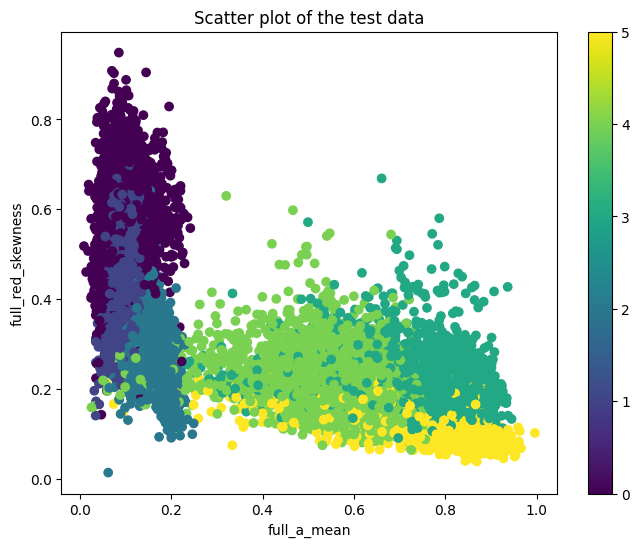

Confusion matrix:


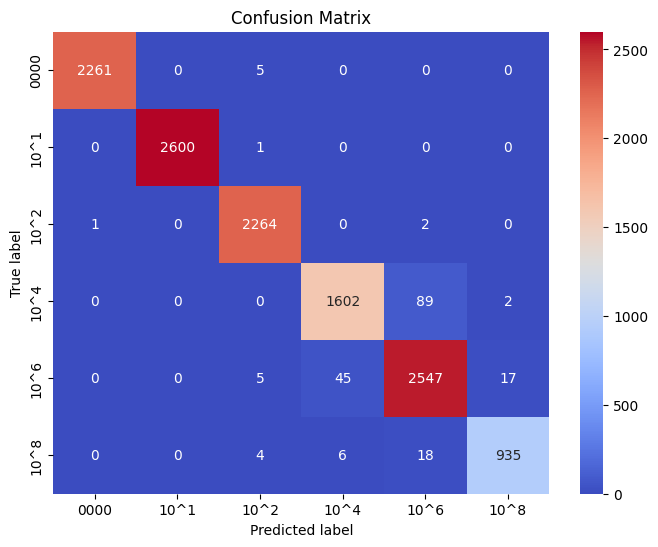

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      1.00      1.00      2267
        10^4       0.97      0.95      0.96      1693
        10^6       0.96      0.97      0.97      2614
        10^8       0.98      0.97      0.98       963

    accuracy                           0.98     12404
   macro avg       0.98      0.98      0.98     12404
weighted avg       0.98      0.98      0.98     12404



In [20]:
# Apply XGBoost
import xgboost as xgb
from sklearn.metrics import silhouette_score

# Set the number of estimators
n_estimators = 10

# Create an instance of the classifier
clf = xgb.XGBClassifier(n_estimators=n_estimators)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

We apply hierarchical clustering

In [21]:
# # Apply hierarchical clustering
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import accuracy_score, silhouette_score

# n_clusters = 6

# classifier = AgglomerativeClustering(n_clusters=n_clusters)
# classifier.fit(X_train)
# y_pred = classifier.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Calculate the silhouette score
# silhouette = silhouette_score(X_test, y_pred)
# print(f"Silhouette score: {silhouette}")

# # Plot the data with predicted clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('Agglomerative Clustering')
# plt.colorbar()
# plt.show()

We apply KNN

Accuracy: 0.9850048371493066
Scatter plot of the test data:


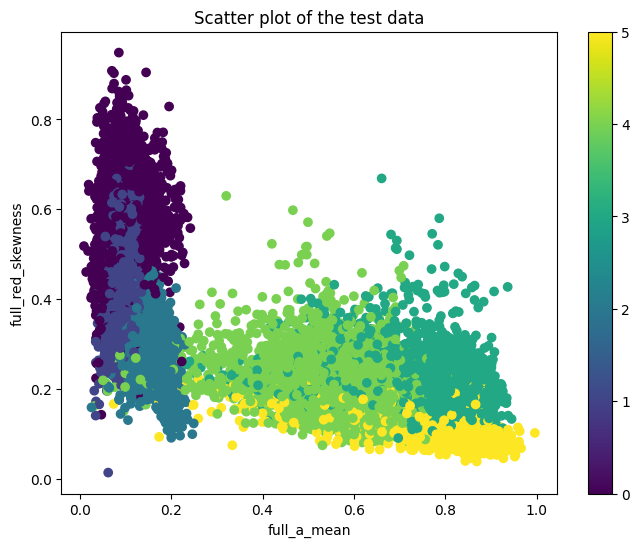

Confusion matrix:


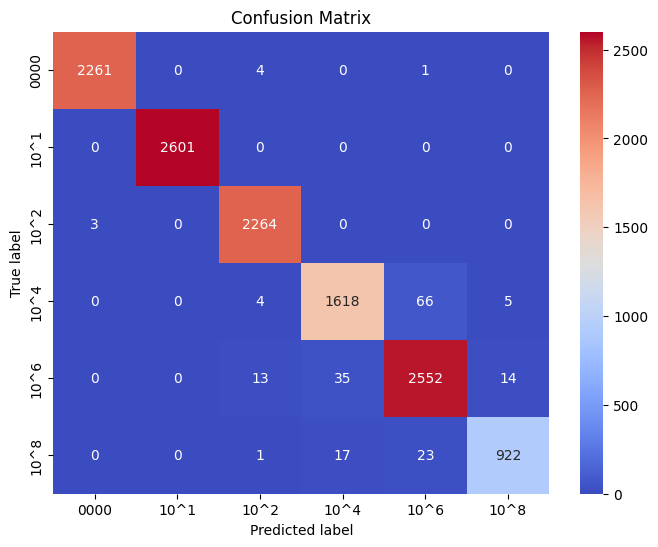

Classification Report:
              precision    recall  f1-score   support

        0000       1.00      1.00      1.00      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.99      1.00      0.99      2267
        10^4       0.97      0.96      0.96      1693
        10^6       0.97      0.98      0.97      2614
        10^8       0.98      0.96      0.97       963

    accuracy                           0.99     12404
   macro avg       0.98      0.98      0.98     12404
weighted avg       0.99      0.99      0.98     12404



In [22]:
# Apply KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Set the number of neighbors
n_neighbors = 7

# Create an instance of the classifier
clf = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels
y_pred = clf.predict(X_test)

# Print the full classification report
print_full_classification_report(y_test, y_pred, X_test=X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

### Deep learning

In [23]:
%pip install tensorflow
%pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
from numpy.typing import NDArray
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle

# Import the data from pickle files
df_numeric_dropped_chi2_sorted = pickle.load(open('df_numeric_dropped_chi2_sorted.pkl', 'rb'))
X = pickle.load(open('X_numeric.pkl', 'rb'))

# Set train, test and validation data
X: NDArray[np.float64] = X
y = pd.get_dummies(df_numeric_dropped_chi2_sorted["class_target"])
y = y.to_numpy(dtype=np.int32)
# y = y.to_numpy(dtype=np.float64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_valid shape: {X_valid.shape}")
print(f"X valid example: {X_valid[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_valid shape: {y_valid.shape}")
print(f"y_valid example: {y_valid[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

X_train shape: (39689, 10)
X train example: [0.60151713 0.32237795 0.14051095 0.96806215 0.06214849 0.62527108
 0.47273322 0.4702654  0.02017982 0.35547848]

X_valid shape: (9923, 10)
X valid example: [0.09819351 0.65589274 0.47627737 0.64734811 0.12514905 0.60425129
 0.36873767 0.71963027 0.03407778 0.38645001]

X_test shape: (12404, 10)
X test example: [0.10281676 0.37467539 0.01824818 0.62027645 0.1724398  0.35492347
 0.53003356 0.42169644 0.01913812 0.56865905]

y_train shape: (39689, 6)
y_train example: [0 0 0 0 1 0]

y_valid shape: (9923, 6)
y_valid example: [1 0 0 0 0 0]

y_test shape: (12404, 6)
y_test example: [0 1 0 0 0 0]



In [25]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(5, activation='relu', input_shape=(X_train.shape[-1],), kernel_regularizer=reg),
        tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ]
)

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

model.summary()


# Plot the model architecture (you need to have Graphviz installed on your machine)
# plot_model(model, show_shapes=True, show_layer_names=True)

2024-08-07 15:30:30.468012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-07 15:30:31.351988: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=512, verbose=1)

# Save the model and history to a file
model.save('model_numeric.keras')
pickle.dump(history, open('history_numeric.pkl', 'wb'))

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2097 - loss: 1.7756 - mae: 0.2763 - mse: 0.1379 - val_accuracy: 0.2068 - val_loss: 1.7563 - val_mae: 0.2746 - val_mse: 0.1368
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2129 - loss: 1.7324 - mae: 0.2734 - mse: 0.1356 - val_accuracy: 0.2480 - val_loss: 1.6418 - val_mae: 0.2681 - val_mse: 0.1307
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3288 - loss: 1.5830 - mae: 0.2641 - mse: 0.1274 - val_accuracy: 0.6073 - val_loss: 1.4035 - val_mae: 0.2502 - val_mse: 0.1166
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6277 - loss: 1.3416 - mae: 0.2445 - mse: 0.1127 - val_accuracy: 0.6669 - val_loss: 1.1703 - val_mae: 0.2270 - val_mse: 0.1016
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6867 - loss: 1.1191 - mae: 0.2210 - mse: 0.0982 - val_accuracy: 0.7010 - val_loss: 0.9921 - val_mae: 0.2047 - val_mse: 0.0894
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

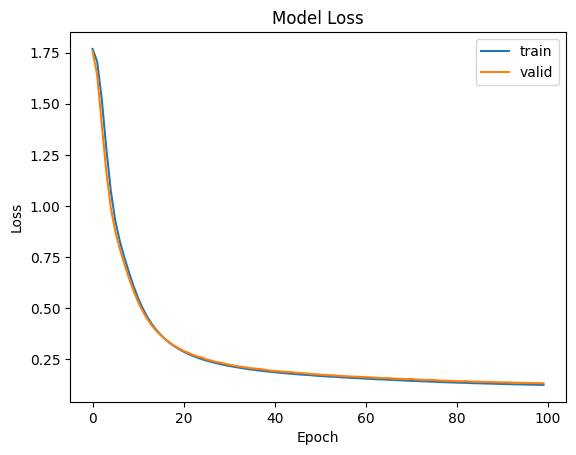

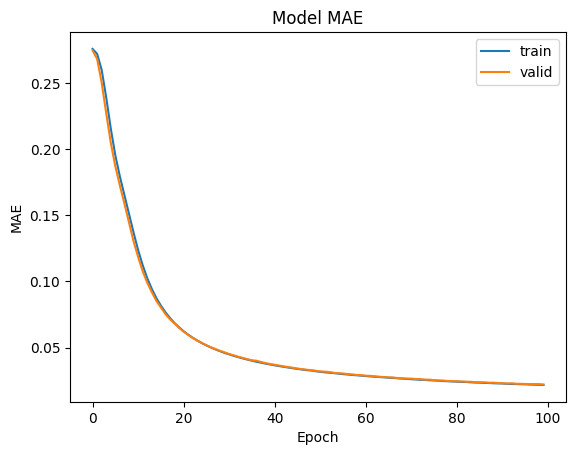

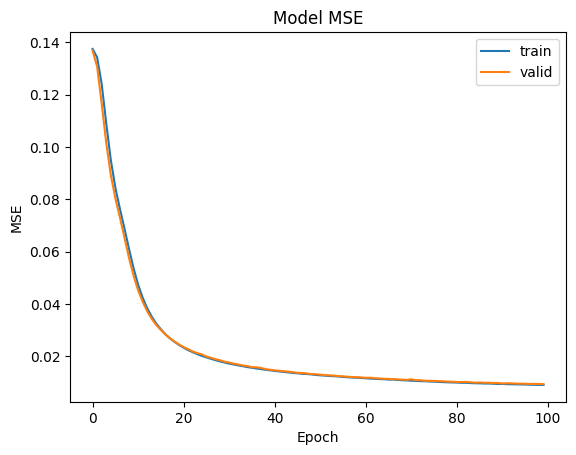

In [27]:
# Import the model and history from a file
import pickle
import tensorflow as tf

model = tf.keras.models.load_model('model_numeric.keras')
history = pickle.load(open('history_numeric.pkl', 'rb'))

create_training_history_plot(history)

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9670 - loss: 0.1196 - mae: 0.0215 - mse: 0.0088
Loss: 0.11992638558149338
Accuracy: 0.9676716923713684
Mean Absolute Error: 0.021397236734628677
Mean Squared Error: 0.008831487037241459
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
First 10 predictions: [1 0 2 4 4 5 2 1 5 1]
Accuracy: 0.9676717188003869
Scatter plot of the test data:


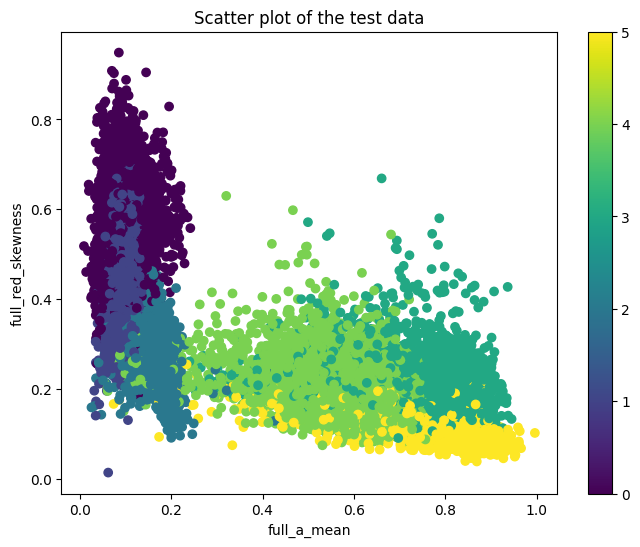

Confusion matrix:


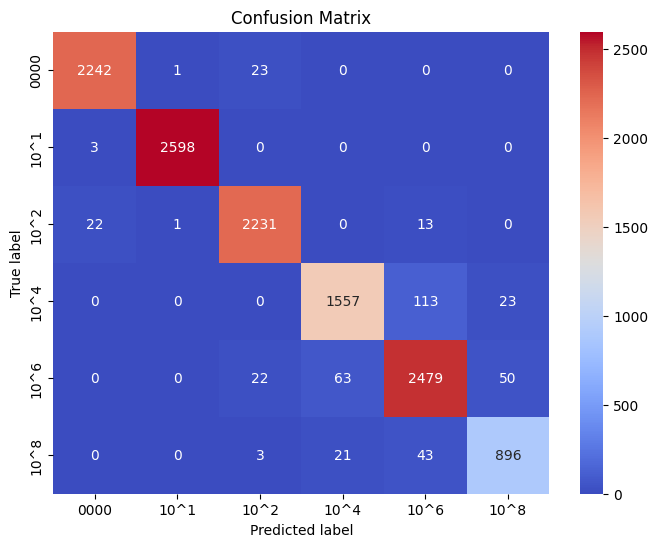

Classification Report:
              precision    recall  f1-score   support

        0000       0.99      0.99      0.99      2266
        10^1       1.00      1.00      1.00      2601
        10^2       0.98      0.98      0.98      2267
        10^4       0.95      0.92      0.93      1693
        10^6       0.94      0.95      0.94      2614
        10^8       0.92      0.93      0.93       963

    accuracy                           0.97     12404
   macro avg       0.96      0.96      0.96     12404
weighted avg       0.97      0.97      0.97     12404



In [28]:
# Evaluate the model
loss, accuracy, mae, mse = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Predict the test data
y_pred = model.predict(X_test)

# Print accuracy
y_pred_1d = np.argmax(y_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

print(f"First 10 predictions: {y_pred_1d[:10]}")

# Print full classification report
print_full_classification_report(y_test_1d, y_pred_1d, X_test, axes_names=CLASSIFICATION_PLOT_AXES, classes_names=CLASSES_SHORT)

## Regression

In [29]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Set the dataset
df_numeric_dropped_chi2_sorted = pickle.load(open('df_numeric_dropped_chi2_sorted.pkl', 'rb'))

# We perform min max scaling because scaling is required for many models to perform well, other models won't be affected negatively
scaler = MinMaxScaler()
FEATURES_COLUMNS = get_features(df_numeric_dropped_chi2_sorted)

X = scaler.fit_transform(df_numeric_dropped_chi2_sorted[FEATURES_COLUMNS])
y = df_numeric_dropped_chi2_sorted["value_target"].to_numpy()

# Set the test size
test_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X train example: {X_train[0]}\n")

print(f"X_test shape: {X_test.shape}")
print(f"X test example: {X_test[0]}\n")

print(f"y_train shape: {y_train.shape}")
print(f"y_train example: {y_train[0]}\n")

print(f"y_test shape: {y_test.shape}")
print(f"y_test example: {y_test[0]}\n")

# Save to pickle files
pickle.dump(X, open('X_numeric_regression.pkl', 'wb'))
pickle.dump(X_train, open('X_numeric_train_regression.pkl', 'wb'))
pickle.dump(X_test, open('X_numeric_test_regression.pkl', 'wb'))
pickle.dump(y, open('y_numeric_regression.pkl', 'wb'))
pickle.dump(y_train, open('y_numeric_train_regression.pkl', 'wb'))
pickle.dump(y_test, open('y_numeric_test_regression.pkl', 'wb'))

X_train shape: (49612, 10)
X train example: [0.05826815 0.38631179 0.51459854 0.6063438  0.13494003 0.3510117
 0.48131182 0.51005743 0.01841794 0.51656526]

X_test shape: (12404, 10)
X test example: [0.10281676 0.37467539 0.01824818 0.62027645 0.1724398  0.35492347
 0.53003356 0.42169644 0.01913812 0.56865905]

y_train shape: (49612,)
y_train example: 0.217

y_test shape: (12404,)
y_test example: 0.275



We use the mean of the target value as baseline model

In [30]:
import numpy as np

# Calculate the mean of the target variable in the training set
mean_train = np.mean(y_train)

# Predict the mean for all instances in the test set
y_pred = np.full_like(y_test, mean_train)

print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.1535707778169625
Mean squared error: 0.05220064767296237
Mean relative error: 0.4167235512808918


We use Linear Regression

In [31]:
# Do regression using Linear Regression
from sklearn.linear_model import LinearRegression

# Set the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.0706187638595955
Mean squared error: 0.011343992036360646
Mean relative error: 0.17599709323548665


We use Random Forest Regressor

In [32]:
# Do regression using Random Forest
from sklearn.ensemble import RandomForestRegressor

# Set the model
model = RandomForestRegressor(n_estimators=50)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.01598615552162589
Mean squared error: 0.0020508112920965597
Mean relative error: 0.030996250960270866


We use XGBoost

In [33]:
# Do regression using XGBoost
import xgboost as xgb

# Set the model
model = xgb.XGBRegressor(n_estimators=50)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.018576150883939414
Mean squared error: 0.002033663406789088
Mean relative error: 0.037640320802416194


We use KNN Regressor

In [34]:
# Do regression using KNN
from sklearn.neighbors import KNeighborsRegressor

# Set the model
model = KNeighborsRegressor(n_neighbors=7)

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.0193129059750311
Mean squared error: 0.002996459422240357
Mean relative error: 0.036303046121794684


We use SVR (Support Vector Regressor)

In [35]:
# Do regression using SVR
from sklearn.svm import SVR

# Set the model
model = SVR()

# Train the model
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)

# Print full regression report
print_full_regression_report(y_test, y_pred)

Mean absolute error: 0.047335176503956446
Mean squared error: 0.005353466031260001
Mean relative error: 0.12126576065215144


### Deep learning

We create one neural network and we train 3 different models: one with no scaling, one with MinMaxScaler and one with StandardScaler

In [36]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Identity Scaler
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    # def fit_transform(self, X):
    #     return X


# Set the dataset
df_numeric_dropped_chi2_sorted = pickle.load(open('df_numeric_dropped_chi2_sorted.pkl', 'rb'))
FEATURES_COLUMNS = get_features(df_numeric_dropped_chi2_sorted)
scalers = [IdentityScaler(), MinMaxScaler(), StandardScaler()]
scaler_names = ["No scaling", "Min-Max Scaler", "Standard Scaler"]

test_size = 0.2

X_raw = df_numeric_dropped_chi2_sorted[FEATURES_COLUMNS].to_numpy()
y_raw = df_numeric_dropped_chi2_sorted["value_target"].to_numpy()

Xs = []
ys = []

scaled_datasets = []

for i in range(len(scalers)):
    scaler = scalers[i]
    
    X = scaler.fit_transform(X_raw)
    # y = scaler.fit_transform(y_raw.reshape(-1, 1))
    y = y_raw.reshape(-1, 1)
    
#     print(f"Testing {scaler_names[i]} (ACTUALLY just NO SCALER WILL PASS)")
    
#     assert len(y_raw.reshape(-1, 1)) == len(y)
    
#     for j in range(len(y)):
#         assert y_raw.reshape(-1, 1)[j] == y[j], f"Error with {j}"
    
    Xs.append(X)
    ys.append(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

    scaled_datasets.append([X_train, X_valid, X_test, y_train, y_valid, y_test])
    
    print(f"Data scaled with: {scaler_names[i]}")
    print(f"\tX_train shape: {X_train.shape}")
    print(f"\tX train example: {X_train[0]}\n")

    print(f"\tX_valid shape: {X_valid.shape}")
    print(f"\tX valid example: {X_valid[0]}\n")

    print(f"\tX_test shape: {X_test.shape}")
    print(f"\tX test example: {X_test[0]}\n")

    print(f"\ty_train shape: {y_train.shape}")
    print(f"\ty_train example: {y_train[0]}\n")

    print(f"\ty_valid shape: {y_valid.shape}")
    print(f"\ty_valid example: {y_valid[0]}\n")

    print(f"\ty_test shape: {y_test.shape}")
    print(f"\ty_test example: {y_test[0]}\n")

    # # Save to pickle files
    # pickle.dump(X, open('X_numeric_regression_deep.pkl', 'wb'))
    # pickle.dump(X_train, open('X_numeric_train_regression_deep.pkl', 'wb'))
    # pickle.dump(X_valid, open('X_numeric_valid_regression_deep.pkl', 'wb'))
    # pickle.dump(X_test, open('X_numeric_test_regression_deep.pkl', 'wb'))
    # pickle.dump(y, open('y_numeric_regression_deep.pkl', 'wb'))
    # pickle.dump(y_train, open('y_numeric_train_regression_deep.pkl', 'wb'))
    # pickle.dump(y_valid, open('y_numeric_valid_regression_deep.pkl', 'wb'))
    # pickle.dump(y_test, open('y_numeric_test_regression_deep.pkl', 'wb'))

Data scaled with: No scaling
	X_train shape: (39689, 10)
	X train example: [ 1.43111937e+02 -9.60734138e-01  1.77000000e+02  1.43242583e+02
  1.68363341e+00 -1.59542263e-01  8.61318425e+01  2.31304959e+00
 -1.66874845e+00  6.41838740e+01]

	X_valid shape: (9923, 10)
	X valid example: [ 1.29061219e+02 -1.24557387e-02  3.61000000e+02  9.57870468e+01
  3.39035008e+00 -2.17443995e-01  6.71838873e+01  3.53957683e+00
 -1.46032350e+00  6.97759787e+01]

	X_test shape: (12404, 10)
	X test example: [129.19028106  -0.81203749 110.          91.78129761   4.67148
  -0.90424945  96.57194641   2.07415811  -1.68437068 102.67496717]

	y_train shape: (39689, 1)
	y_train example: [0.579]

	y_valid shape: (9923, 1)
	y_valid example: [0.202]

	y_test shape: (12404, 1)
	y_test example: [0.275]

Data scaled with: Min-Max Scaler
	X_train shape: (39689, 10)
	X train example: [0.60151713 0.32237795 0.14051095 0.96806215 0.06214849 0.62527108
 0.47273322 0.4702654  0.02017982 0.35547848]

	X_valid shape: (9923, 

In [37]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # Scale X
# scaler.fit(X)

# X_train_scaled = scaler.transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)
# X_test_scaled = scaler.transform(X_test)

# # Scale y
# scaler.fit(y.reshape(-1, 1))

# y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
# y_valid_scaled = scaler.transform(y_valid.reshape(-1, 1))
# y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

In [38]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)
models = []

for i in range(len(scalers)):
    models.append(tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(5, activation='relu', input_shape=(Xs[i].shape[-1],), kernel_regularizer=reg),
                tf.keras.layers.Dense(5, activation='relu', kernel_regularizer=reg),
                tf.keras.layers.Dense(1, activation='linear')
            ]
        )
    )

for model in models:
    optimizer = tf.keras.optimizers.Adam()
    optimizer_scaled = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanSquaredError()
    loss_function_scaled = tf.keras.losses.MeanSquaredError()

    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'mse'])
    model.summary()
    
    # I don't know why this plot is not printing
    # plot_model(model, show_shapes=True, show_layer_names=True)
    

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
histories = []

for i in range(len(models)):
    print(f"\nTraining neural network with data scaled with {scaler_names[i]}")
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=2048, verbose=1)
    histories.append(history)


Training neural network with data scaled with No scaling
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3353.3611 - mae: 55.9238 - mse: 3353.3599 - val_loss: 2235.3362 - val_mae: 45.4755 - val_mse: 2235.3352
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1937.9017 - mae: 42.0883 - mse: 1937.9008 - val_loss: 1216.3833 - val_mae: 33.0564 - val_mse: 1216.3824
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1035.5729 - mae: 30.2439 - mse: 1035.5720 - val_loss: 627.9751 - val_mae: 23.0140 - val_mse: 627.9743
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 528.8655 - mae: 20.7861 - mse: 528.8646 - val_loss: 317.2625 - val_mae: 15.2477 - val_mse: 317.2617
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 269.5523 - mae: 13.6328 - mse: 269.5516 - val_loss: 168.3145 - val_mae: 9.7371 - val_mse: 168.3137
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148.9927 - mae: 8.7676 - mse: 148.9919 - val_loss: 100.3671 - val_mae: 6.5231 


Showing history of training of neural network with data scaled with No scaling


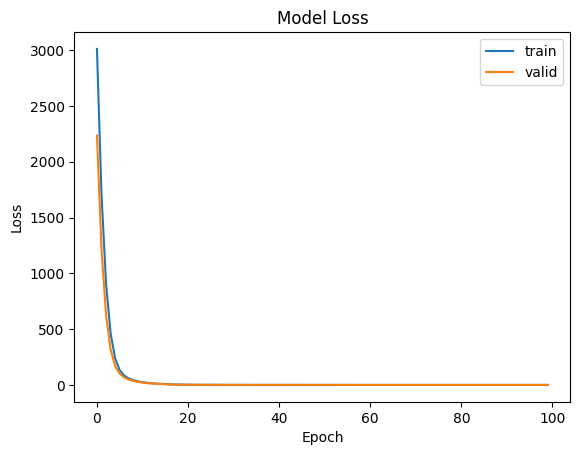

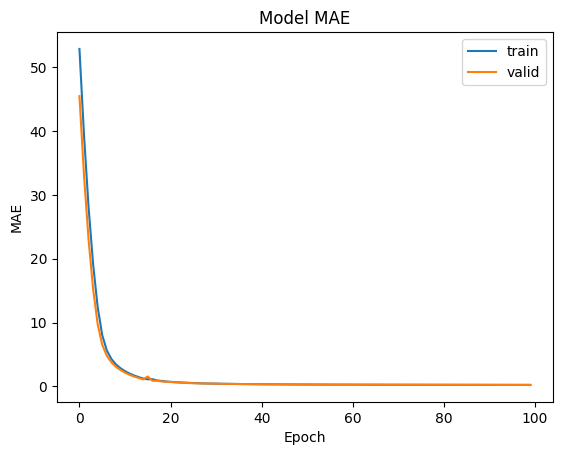

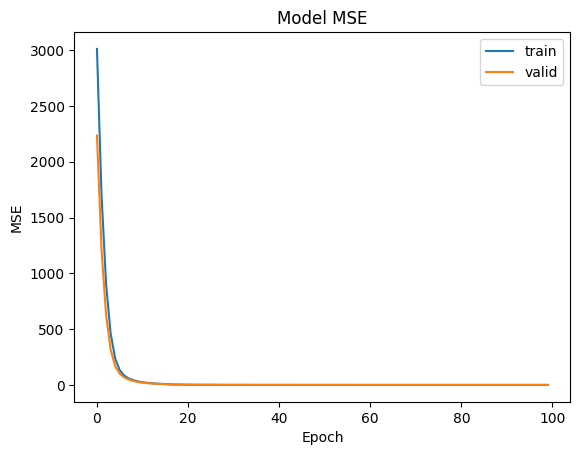


Showing history of training of neural network with data scaled with Min-Max Scaler


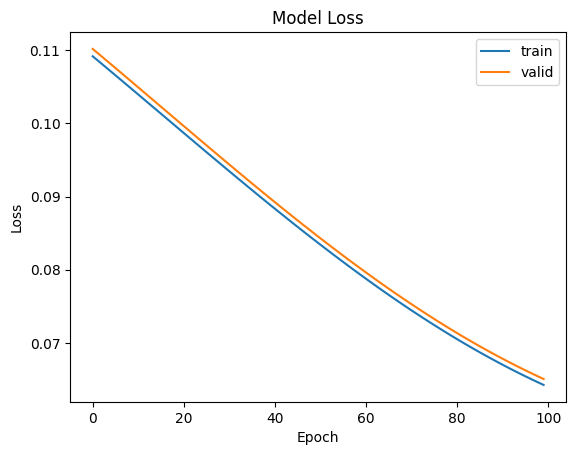

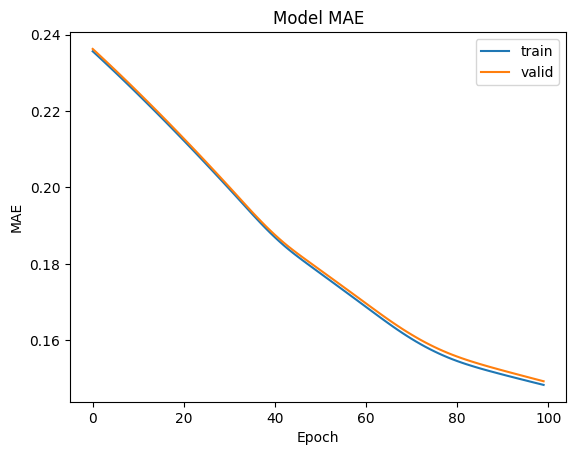

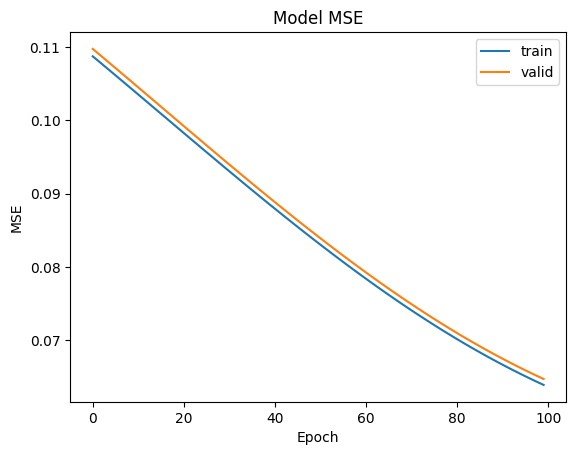


Showing history of training of neural network with data scaled with Standard Scaler


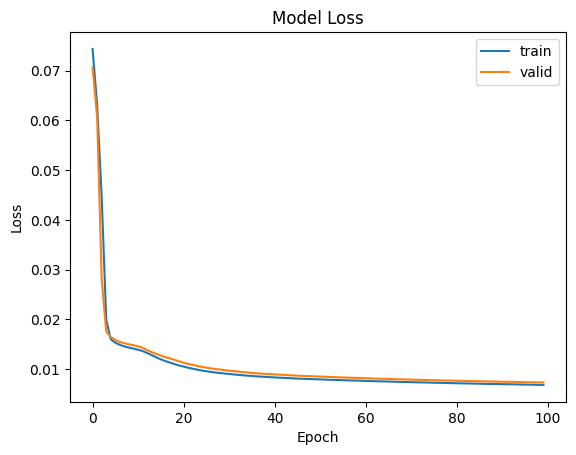

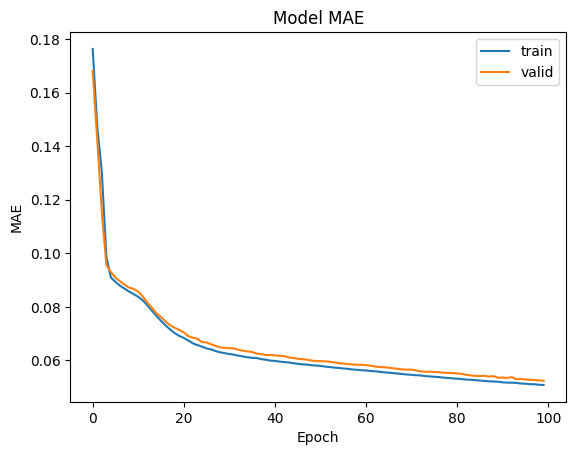

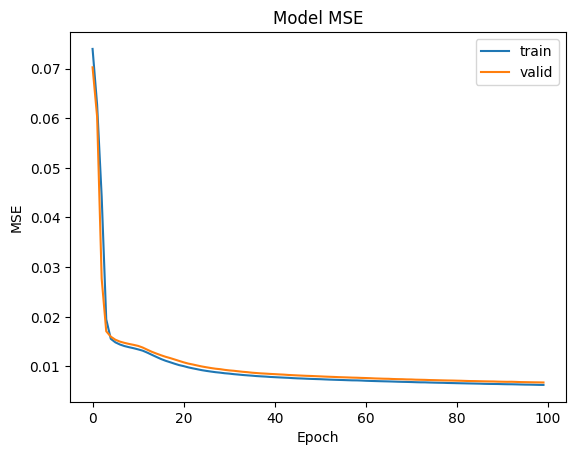

In [40]:
for i in range(len(histories)):
    print(f"\nShowing history of training of neural network with data scaled with {scaler_names[i]}")
    create_training_history_plot(histories[i])

In [41]:
for i in range(len(models)):
    model = models[i]
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    print(f"\nEvaluating model trained with data scaled with {scaler_names[i]}")
    
    loss, mae, mse = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")

    # Predict the test data
    y_pred = model.predict(X_test)

    # Print full regression report
    print_full_regression_report(y_test, y_pred)


Evaluating model trained with data scaled with No scaling
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 2562.9509 - mae: 48.1957 - mse: 2562.9497
Loss: 2559.58837890625
Mean Absolute Error: 48.068687438964844
Mean Squared Error: 2559.587158203125
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
Mean absolute error: 48.06869808846541
Mean squared error: 2559.5865746117834
Mean relative error: 138.03294254368527

Evaluating model trained with data scaled with Min-Max Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.1053 - mae: 0.2286 - mse: 0.1041
Loss: 0.10254673659801483
Mean Absolute Error: 0.226618692278862
Mean Squared Error: 0.10132742673158646
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
Mean absolute error: 0.22661864865416806
Mean squared error: 0.10132737843657244
Mean relative error: 0.5783135526018455

Evaluating model trained with data scaled with Standard Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0071 - mae: 0.0504 - mse: 0.0065
Loss: 0.0069902110

In [42]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

reg = tf.keras.regularizers.l2(0.0001)
models_v2 = []

for i in range(len(scalers)):
    models_v2.append(
        tf.keras.models.Sequential(
            [
                tf.keras.layers.Dense(128, activation='relu', input_shape=(Xs[i].shape[-1],), kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(256, activation='relu', kernel_initializer='normal', kernel_regularizer=reg),
                tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal', kernel_regularizer=reg)
            ]
        )
    )

for model in models_v2:
    optimizer = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanAbsoluteError()

    
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'mse'])
    model.summary()
    
    # I don't know why this plot is not printing
    # plot_model(model, show_shapes=True, show_layer_names=True)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,273 (649.50 KB)

 Trainable params: 166,273 (649.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,273 (649.50 KB)

 Trainable params: 166,273 (649.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,273 (649.50 KB)

 Trainable params: 166,273 (649.50 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
histories_v2 = []

for i in range(len(models_v2)):
    print(f"\nTraining neural network with data scaled with {scaler_names[i]}")
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=2048, verbose=1)
    histories_v2.append(history)


Training neural network with data scaled with No scaling
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.2850 - mae: 1.2460 - mse: 3.5102 - val_loss: 0.2056 - val_mae: 0.1733 - val_mse: 0.0716
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1565 - mae: 0.1257 - mse: 0.0482 - val_loss: 0.1185 - val_mae: 0.0915 - val_mse: 0.0411
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1178 - mae: 0.0917 - mse: 0.0382 - val_loss: 0.1089 - val_mae: 0.0850 - val_mse: 0.0366
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1053 - mae: 0.0818 - mse: 0.0343 - val_loss: 0.1023 - val_mae: 0.0800 - val_mse: 0.0311
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1032 - mae: 0.0812 - mse: 0.0310 - val_loss: 0.0991 - val_mae: 0.0779 - val_mse: 0.0288
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0979 - mae: 0.0768 - mse: 0.0279 - val_loss: 0.0964 - val_mae: 0.0759 - val_mse: 0.0289
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 


Showing history of training of neural network with data scaled with Standard Scaler


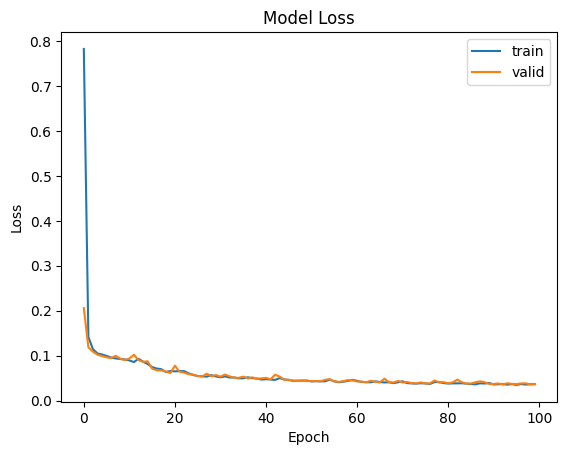

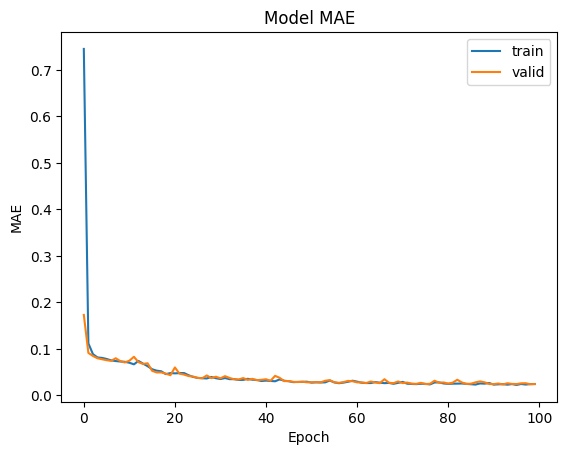

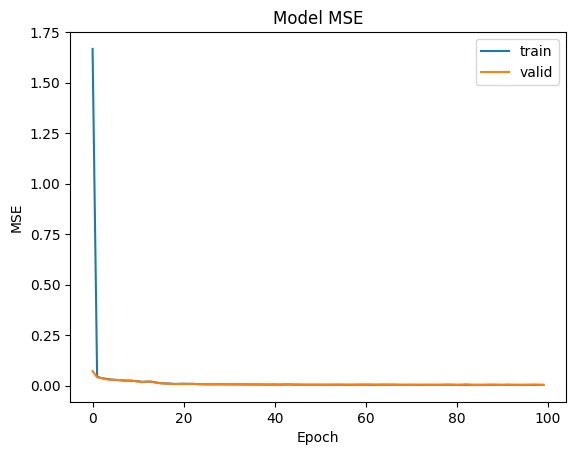


Showing history of training of neural network with data scaled with Standard Scaler


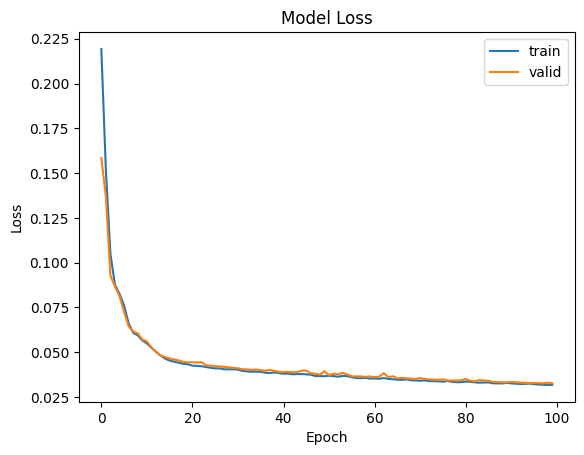

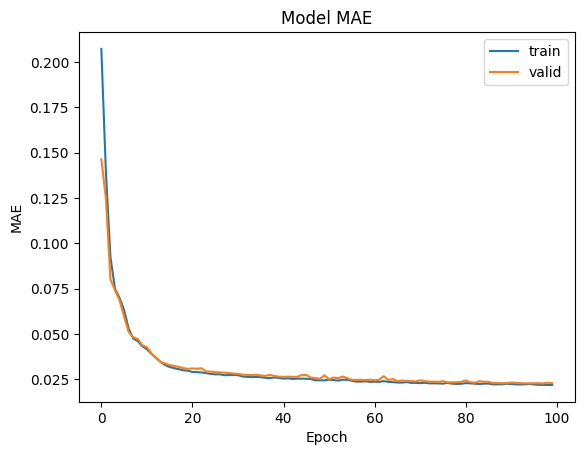

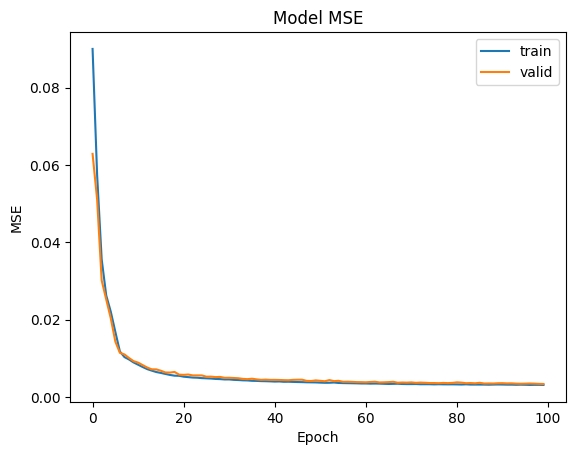


Showing history of training of neural network with data scaled with Standard Scaler


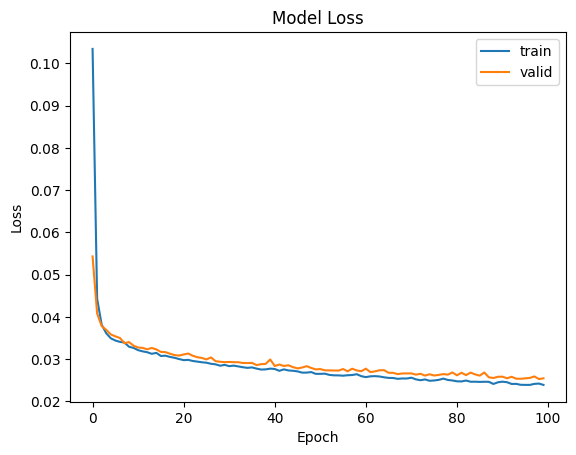

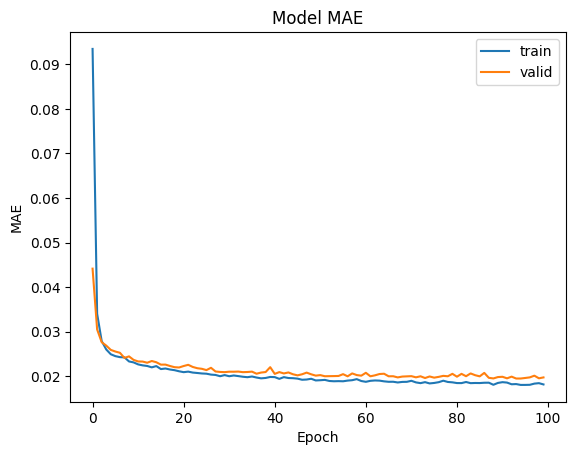

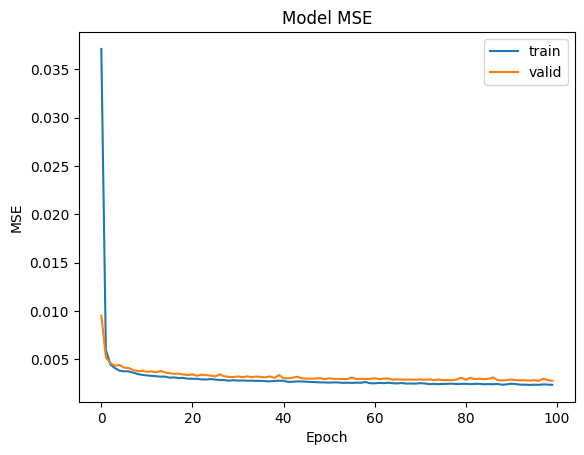

In [44]:
for history in histories_v2:
    print(f"\nShowing history of training of neural network with data scaled with {scaler_names[i]}")
    create_training_history_plot(history)

In [45]:
for i in range(len(models_v2)):
    model = models_v2[i]
    X_train, X_valid, X_test, y_train, y_valid, y_test = scaled_datasets[i]
    print(f"\nEvaluating model trained with data scaled with {scaler_names[i]}")
    
    # Evaluate the model
    loss, mae, mse = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")

    # Predict the test data
    y_pred = model.predict(X_test)

    # Print full regression report
    print_full_regression_report(y_test, y_pred)


Evaluating model trained with data scaled with No scaling
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4130 - mae: 0.3717 - mse: 0.1527
Loss: 0.4134250283241272
Mean Absolute Error: 0.3721417188644409
Mean Squared Error: 0.15308710932731628
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean absolute error: 0.3721418763668989
Mean squared error: 0.15308720103805482
Mean relative error: 1.1432866409103266

Evaluating model trained with data scaled with Min-Max Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4404 - mae: 0.3990 - mse: 0.2129
Loss: 0.4378341734409332
Mean Absolute Error: 0.39640098810195923
Mean Squared Error: 0.20923466980457306
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean absolute error: 0.3964010918282635
Mean squared error: 0.20923467834110526
Mean relative error: 1.0102910473725117

Evaluating model trained with data scaled with Standard Scaler
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0246 - mae: 0.0189 - mse: 0.0026
Loss: 0.02460225857794284